In [15]:
%matplotlib inline
# plotting
# import matplotlib.pyplot as plt
# array operations
import numpy as np
# reading in data
import pandas as pd
# distributions
import scipy.stats as stats
# machine learning
from sklearn import metrics
from sklearn.utils.extmath import density

from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import ComplementNB #very fast
from sklearn.linear_model import SGDClassifier #very fast
from sklearn.ensemble import ExtraTreesClassifier #14m, average precision: 0.4033
from sklearn.ensemble import RandomForestClassifier #>14m
from sklearn.ensemble import GradientBoostingClassifier #45m

from sklearn.model_selection import RandomizedSearchCV

# system time
import time

In [16]:
def benchmark(clf):
    # timing the training of the classifier
    print('_' * 72, 
          "Training: ", 
          clf, 
          sep='\n')
    t0 = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - t0
    print(f"train time: {train_time:.4f}s")

    # timing the prediction of the classifier
    t0 = time.time()
    pred = clf.predict(X_val)
    predict_time = time.time() - t0
    print(f"predict time: {predict_time:.4f}s")

    # calculating average precision (the area under the precision-recall curve)
    score = metrics.average_precision_score(y_val, pred)
    print(f"average precision: {score:.4f}")

    # study model coefficients
    coefs = None
    if hasattr(clf, 'coef_'):
        coefs = clf.coef_
    elif hasattr(clf, 'feature_importances_'):
        coefs = clf.feature_importances_.reshape(1, -1)
        
    if isinstance(coefs, np.ndarray):
        print(f"dimensionality: {coefs.shape[1]}", # number of coefficients
              f"density: {density(coefs)}", # non-zero coefficient density
              "top 10 words indicating toxic:",
              sep='\n')
        # indices of largest 10 coefficients
        top10 = np.argsort(coefs[0])[-10:]
        # top 10 features indicating toxic
        print(feature_names[top10])

        print("top 10 words indicating not toxic:")
        # indices of smallest 10 coefficients
        btm10 = np.argsort(coefs[0])[:10]
        # top 10 features indicating not toxic
        print(feature_names[btm10])

        # classification report
        print("classification report:")
        print(metrics.classification_report(y_val, pred, target_names=['not toxic', 'toxic']))
        
        # confusion matrix on validation set
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_val, pred))
    
    # sklearn model name
    clf_descr = str(clf).split('(')[0]
    
    return clf, clf_descr, score, train_time, predict_time


# report best scores
def report(results, n_top=20):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}", 
                  f"Mean validation score: {results['mean_test_score'][candidate]:.4f} "
                  f"(std: {results['std_test_score'][candidate]:.4f})",
                  f"Mean fit time: {results['mean_fit_time'][candidate]:.4f} "
                  f"(std: {results['std_fit_time'][candidate]:.4f})",
                  f"Mean score time: {results['mean_score_time'][candidate]:.4f} "
                  f"(std: {results['std_score_time'][candidate]:.4f})",
                  f"Parameters: {results['params'][candidate]}", 
                  sep='\n')

In [17]:
#####################################
# NMSLIB approximate-nearest neighbors sklearn wrapper
# NMSLIB: https://github.com/nmslib/nmslib
# Wrapper author: Davi Sidarta-Oliveira
# School of Medical Sciences,University of Campinas,Brazil
# contact: davisidarta@gmail.com
######################################

import time
import sys
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from scipy.sparse import csr_matrix, find, issparse
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

try:
    import nmslib
except ImportError:
    print("The package 'nmslib' is required. Please install it 'with pip3 install nmslib'.")
    sys.exit()

print(__doc__)


class NMSlibTransformer(TransformerMixin, BaseEstimator):
    """
    Wrapper for using nmslib as sklearn's KNeighborsTransformer. This implements
    an escalable approximate k-nearest-neighbors graph on spaces defined by nmslib.
    Read more about nmslib and its various available metrics at
    https://github.com/nmslib/nmslib.
    Calling 'nn <- NMSlibTransformer()' initializes the class with
     neighbour search parameters.
    Parameters
    ----------
    n_neighbors: int (optional, default 30)
        number of nearest-neighbors to look for. In practice,
        this should be considered the average neighborhood size and thus vary depending
        on your number of features, samples and data intrinsic dimensionality. Reasonable values
        range from 5 to 100. Smaller values tend to lead to increased graph structure
        resolution, but users should beware that a too low value may render granulated and vaguely
        defined neighborhoods that arise as an artifact of downsampling. Defaults to 30. Larger
        values can slightly increase computational time.
    metric: str (optional, default 'cosine')
        accepted NMSLIB metrics. Defaults to 'cosine'. Accepted metrics include:
        -'sqeuclidean'
        -'euclidean'
        -'l1'
        -'lp' - requires setting the parameter `p`
        -'cosine'
        -'angular'
        -'negdotprod'
        -'levenshtein'
        -'hamming'
        -'jaccard'
        -'jansen-shan'
    method: str (optional, default 'hsnw')
        approximate-neighbor search method. Available methods include:
                -'hnsw' : a Hierarchical Navigable Small World Graph.
                -'sw-graph' : a Small World Graph.
                -'vp-tree' : a Vantage-Point tree with a pruning rule adaptable to non-metric distances.
                -'napp' : a Neighborhood APProximation index.
                -'simple_invindx' : a vanilla, uncompressed, inverted index, which has no parameters.
                -'brute_force' : a brute-force search, which has no parameters.
        'hnsw' is usually the fastest method, followed by 'sw-graph' and 'vp-tree'.
    n_jobs: int (optional, default 1)
        number of threads to be used in computation. Defaults to 1. The algorithm is highly
        scalable to multi-threading.
    M: int (optional, default 30)
        defines the maximum number of neighbors in the zero and above-zero layers during HSNW
        (Hierarchical Navigable Small World Graph). However, the actual default maximum number
        of neighbors for the zero layer is 2*M.  A reasonable range for this parameter
        is 5-100. For more information on HSNW, please check https://arxiv.org/abs/1603.09320.
        HSNW is implemented in python via NMSlib. Please check more about NMSlib at https://github.com/nmslib/nmslib.
    efC: int (optional, default 100)
        A 'hnsw' parameter. Increasing this value improves the quality of a constructed graph
        and leads to higher accuracy of search. However this also leads to longer indexing times.
        A reasonable range for this parameter is 50-2000.
    efS: int (optional, default 100)
        A 'hnsw' parameter. Similarly to efC, increasing this value improves recall at the
        expense of longer retrieval time. A reasonable range for this parameter is 100-2000.
    dense: bool (optional, default False)
        Whether to force the algorithm to use dense data, such as np.ndarrays and pandas DataFrames.
    Returns
    ---------
    Class for really fast approximate-nearest-neighbors search.
    Example
    -------------
    import numpy as np
    from sklearn.datasets import load_digits
    from scipy.sparse import csr_matrix
    from dbmap.ann import NMSlibTransformer
    #
    # Load the MNIST digits data, convert to sparse for speed
    digits = load_digits()
    data = csr_matrix(digits)
    #
    # Start class with parameters
    nn = NMSlibTransformer()
    nn = nn.fit(data)
    #
    # Obtain kNN graph
    knn = nn.transform(data)
    #
    # Obtain kNN indices, distances and distance gradient
    ind, dist, grad = nn.ind_dist_grad(data)
    #
    # Test for recall efficiency during approximate nearest neighbors search
    test = nn.test_efficiency(data)
    """

    def __init__(self,
                 n_neighbors=30,
                 metric='cosine',
                 method='hnsw',
                 n_jobs=10,
                 p=None,
                 M=30,
                 efC=100,
                 efS=100,
                 dense=False,
                 verbose=False
                 ):

        self.n_neighbors = n_neighbors
        self.method = method
        self.metric = metric
        self.n_jobs = n_jobs
        self.p = p
        self.M = M
        self.efC = efC
        self.efS = efS
        self.space = self.metric

        self.dense = dense
        self.verbose = verbose

    def fit(self, data, y=None):
        # see more metrics in the manual
        # https://github.com/nmslib/nmslib/tree/master/manual

        if self.dense:
            self.nmslib_ = nmslib.init(method=self.method,
                                       space=self.space,
                                       data_type=nmslib.DataType.DENSE_VECTOR)

        else:
            if issparse(data) == True:
                if self.verbose:
                    print('Sparse input. Proceding without converting...')
                if isinstance(data, np.ndarray):
                    data = csr_matrix(data)
            if issparse(data) == False:
                if self.verbose:
                    print('Input data is ' + str(type(data)) + ' .Converting input to sparse...')
                import pandas as pd
                if isinstance(data, pd.DataFrame):
                    data = csr_matrix(data.values.T)

        index_time_params = {'M': self.M, 'indexThreadQty': self.n_jobs, 'efConstruction': self.efC, 'post': 0}

        if issparse(data) and (not self.dense) and (not isinstance(data, np.ndarray)):
            if self.metric not in ['levenshtein', 'hamming', 'jansen-shan', 'jaccard']:
                self.space = {
                    'sqeuclidean': 'l2_sparse',
                    'euclidean': 'l2_sparse',
                    'cosine': 'cosinesimil_sparse_fast',
                    'lp': 'lp_sparse',
                    'l1_sparse': 'l1_sparse',
                    'linf_sparse': 'linf_sparse',
                    'angular_sparse': 'angulardist_sparse_fast',
                    'negdotprod_sparse': 'negdotprod_sparse_fast',
                }[self.metric]
                if self.metric == 'lp' and selp.p is None:
                    print('Metric set to `lp` but `p` not set. Setting `p` as 0.5.')

                if self.metric == 'lp' and selp.p is not None:
                    self.nmslib_ = nmslib.init(method=self.method,
                                               space=self.space,
                                               space_params={'p': self.p},
                                               data_type=nmslib.DataType.SPARSE_VECTOR)
                else:
                    self.nmslib_ = nmslib.init(method=self.method,
                                               space=self.space,
                                               data_type=nmslib.DataType.SPARSE_VECTOR)
            else:
                print('Metric ' + self.metric + 'available for string data only. Trying to compute distances...')
                data = data.toarray()
                self.nmslib_ = nmslib.init(method=self.method,
                                           space=self.space,
                                           data_type=nmslib.DataType.OBJECT_AS_STRING)
        else:
            self.space = {
                'sqeuclidean': 'l2',
                'euclidean': 'l2',
                'cosine': 'cosinesimil',
                'lp': 'lp',
                'l1': 'l1',
                'linf': 'linf',
                'angular': 'angulardist',
                'negdotprod': 'negdotprod',
                'levenshtein': 'leven',
                'hamming': 'bit_hamming',
                'jaccard': 'bit_jaccard',
                'jansen-shan': 'jsmetrfastapprox'
            }[self.metric]
            if self.metric == 'lp':
                self.nmslib_ = nmslib.init(method=self.method,
                                           space=self.space,
                                           space_params={'p': self.p},
                                           data_type=nmslib.DataType.DENSE_VECTOR)
            else:
                self.nmslib_ = nmslib.init(method=self.method,
                                           space=self.space,
                                           data_type=nmslib.DataType.DENSE_VECTOR)

        self.nmslib_.addDataPointBatch(data)
        start = time.time()
        self.nmslib_.createIndex(index_time_params)
        end = time.time()

        if self.verbose:
            print('Index-time parameters', 'M:', self.M, 'n_threads:', self.n_jobs, 'efConstruction:', self.efC,
                  'post:0')
            print('Indexing time = %f (sec)' % (end - start))

        return self

    def transform(self, data):
        start = time.time()
        n_samples_transform = data.shape[0]
        query_time_params = {'efSearch': self.efS}
        if self.verbose:
            print('Query-time parameter efSearch:', self.efS)
        self.nmslib_.setQueryTimeParams(query_time_params)

        # For compatibility reasons, as each sample is considered as its own
        # neighbor, one extra neighbor will be computed.
        self.n_neighbors = self.n_neighbors + 1

        results = self.nmslib_.knnQueryBatch(data, k=self.n_neighbors,
                                             num_threads=self.n_jobs)

        indices, distances = zip(*results)
        indices, distances = np.vstack(indices), np.vstack(distances)

        query_qty = data.shape[0]

        if self.metric == 'sqeuclidean':
            distances **= 2

        indptr = np.arange(0, n_samples_transform * self.n_neighbors + 1,
                           self.n_neighbors)
        kneighbors_graph = csr_matrix((distances.ravel(), indices.ravel(),
                                       indptr), shape=(n_samples_transform,
                                                       n_samples_transform))
        end = time.time()
        if self.verbose:
            print('kNN time total=%f (sec), per query=%f (sec), per query adjusted for thread number=%f (sec)' %
                  (end - start, float(end - start) / query_qty, self.n_jobs * float(end - start) / query_qty))

        return kneighbors_graph

    def ind_dist_grad(self, data, return_grad=True, return_graph=True):

        start = time.time()
        n_samples_transform = data.shape[0]
        query_time_params = {'efSearch': self.efS}
        if self.verbose:
            print('Query-time parameter efSearch:', self.efS)
        self.nmslib_.setQueryTimeParams(query_time_params)
        # For compatibility reasons, as each sample is considered as its own
        # neighbor, one extra neighbor will be computed.
        self.n_neighbors = self.n_neighbors + 1
        results = self.nmslib_.knnQueryBatch(data, k=self.n_neighbors,
                                             num_threads=self.n_jobs)
        indices, distances = zip(*results)
        indices, distances = np.vstack(indices), np.vstack(distances)

        query_qty = data.shape[0]

        if self.metric == 'sqeuclidean':
            distances **= 2

        indptr = np.arange(0, n_samples_transform * self.n_neighbors + 1,
                           self.n_neighbors)
        kneighbors_graph = csr_matrix((distances.ravel(), indices.ravel(),
                                       indptr), shape=(n_samples_transform,
                                                       n_samples_transform))
        if return_grad:
            x, y, dists = find(kneighbors_graph)

            # Define gradients
            grad = []
            if self.metric not in ['sqeuclidean', 'euclidean', 'cosine', 'linf']:
                print('Gradient undefined for metric \'' + self.metric + '\'. Returning empty array.')

            if self.metric == 'cosine':
                norm_x = 0.0
                norm_y = 0.0
                for i in range(x.shape[0]):
                    norm_x += x[i] ** 2
                    norm_y += y[i] ** 2
                if norm_x == 0.0 and norm_y == 0.0:
                    grad = np.zeros(x.shape)
                elif norm_x == 0.0 or norm_y == 0.0:
                    grad = np.zeros(x.shape)
                else:
                    grad = -(x * dists - y * norm_x) / np.sqrt(norm_x ** 3 * norm_y)

            if self.metric == 'euclidean':
                grad = x - y / (1e-6 + np.sqrt(dists))

            if self.metric == 'sqeuclidean':
                grad = x - y / (1e-6 + dists)

            if self.metric == 'linf':
                result = 0.0
                max_i = 0
                for i in range(x.shape[0]):
                    v = np.abs(x[i] - y[i])
                    if v > result:
                        result = dists
                        max_i = i
                grad = np.zeros(x.shape)
                grad[max_i] = np.sign(x[max_i] - y[max_i])

        end = time.time()

        if self.verbose:
            print('kNN time total=%f (sec), per query=%f (sec), per query adjusted for thread number=%f (sec)' %
                  (end - start, float(end - start) / query_qty, self.n_jobs * float(end - start) / query_qty))

        if return_graph and return_grad:
            return indices, distances, grad, kneighbors_graph
        if return_graph and not return_grad:
            return indices, distances, kneighbors_graph
        if not return_graph and return_grad:
            return indices, distances, grad
        if not return_graph and not return_grad:
            return indices, distances

    def test_efficiency(self, data, data_use=0.1):
        """Test if NMSlibTransformer and KNeighborsTransformer give same results
        """
        self.data_use = data_use

        query_qty = data.shape[0]

        (dismiss, test) = train_test_split(data, test_size=self.data_use)
        query_time_params = {'efSearch': self.efS}
        if self.verbose:
            print('Setting query-time parameters', query_time_params)
        self.nmslib_.setQueryTimeParams(query_time_params)

        # For compatibility reasons, as each sample is considered as its own
        # neighbor, one extra neighbor will be computed.
        self.n_neighbors = self.n_neighbors + 1
        start = time.time()
        ann_results = self.nmslib_.knnQueryBatch(data, k=self.n_neighbors,
                                                 num_threads=self.n_jobs)
        end = time.time()
        if self.verbose:
            print('kNN time total=%f (sec), per query=%f (sec), per query adjusted for thread number=%f (sec)' %
                  (end - start, float(end - start) / query_qty, self.n_jobs * float(end - start) / query_qty))

        # Use sklearn for exact neighbor search
        start = time.time()
        nbrs = NearestNeighbors(n_neighbors=self.n_neighbors,
                                metric='cosine',
                                algorithm='brute').fit(data)
        knn = nbrs.kneighbors(data)
        end = time.time()
        if self.verbose:
            print('brute-force gold-standart kNN time total=%f (sec), per query=%f (sec)' %
                  (end - start, float(end - start) / query_qty))

        recall = 0.0
        for i in range(0, query_qty):
            correct_set = set(knn[1][i])
            ret_set = set(ann_results[i][0])
            recall = recall + float(len(correct_set.intersection(ret_set))) / len(correct_set)
        recall = recall / query_qty
        print('kNN recall %f' % recall)

    def update_search(self, n_neighbors):
        """
        Updates number of neighbors for kNN distance computation.
        Parameters
        -----------
        n_neighbors: New number of neighbors to look for.
        """
        self.n_neighbors = n_neighbors

Automatically created module for IPython interactive environment


In [3]:
# read training and testing csvs and testing labels into pandas DataFrames
df_train = pd.read_csv("../data/jigsaw-toxic-comment-classification-challenge/train.csv")
df_test = pd.read_csv("../data/jigsaw-toxic-comment-classification-challenge/test.csv")
df_test_labels = pd.read_csv("../data/jigsaw-toxic-comment-classification-challenge/test_labels.csv")
# merge testing set and testing labels
df_test = pd.merge(df_test, df_test_labels)
# exclude comments with a label of -1, which was not used for competition scoring
df_test = df_test[df_test.toxic != -1]

In [4]:
# split training set into training and validation set
df_train, df_val = train_test_split(df_train, random_state=1935, stratify=df_train.toxic)

strip_accents ascii doesn't improve performance
strip_accents unicode doesn't improve performance
stop_words reduces performance
CountVectorizer is worse that TfidfVectorizer
sublinear_tf improves performance
<50000 features reduces performance 198000
squared_hinge loss reduces performance
perceptron loss reduces performance
including 2+-grams reduces performance
min_df=2-4 best performance
max_df=0.5+ doesn't improve performance

In [5]:
# instantiate tf-idf vectorizer
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    min_df=4,
)

# vectorize data rename labels
X_train = vectorizer.fit_transform(df_train.comment_text)
y_train = df_train.toxic

X_val = vectorizer.transform(df_val.comment_text)
y_val = df_val.toxic

X_test = vectorizer.transform(df_test.comment_text)
y_test = df_test.toxic

# get vocabulary
feature_names = np.asarray(vectorizer.get_feature_names())

In [64]:
clf = SGDClassifier(
    penalty='elasticnet', 
    verbose=51,
    n_jobs=-1,
#     random_state=1724,
    early_stopping=True, 
    class_weight='balanced',
)

# specify parameters and distributions to sample from
param_dist = {
    'loss': ['log', 'hinge'], 
    'alpha': stats.loguniform(1e-6, 1e-4), 
    'l1_ratio': stats.uniform(0, 1),
}

# run randomized search
n_iter_search = 128
random_search = RandomizedSearchCV(
        clf, 
        param_distributions=param_dist, 
        n_iter=n_iter_search, 
        scoring='average_precision', 
        n_jobs=-1, 
        verbose=51, 
#         random_state=1727,
    )

start = time.time()
random_search.fit(X_train, y_train)
print(f"RandomizedSearchCV took {time.time() - start:.2f} seconds for {n_iter_search} candidates")
report(random_search.cv_results_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   53.1s
[Paralle

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  1.7min
[Paralle

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 398 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 399 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 403 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 411 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:  2.5min
[Paralle

[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 531 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 532 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 533 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 534 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 535 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 539 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 542 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 543 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed:  3.4min
[Paralle

In [114]:
benchmark(GradientBoostingClassifier(
#         random_state=1557,
        verbose=51,
        n_iter_no_change=5
    ))

________________________________________________________________________
Training: 
GradientBoostingClassifier(n_iter_no_change=5, verbose=51)
      Iter       Train Loss   Remaining Time 
         1           0.5873           10.14m
         2           0.5682            6.99m
         3           0.5539            5.61m
         4           0.5423            4.73m
         5           0.5344            4.20m
         6           0.5275            3.87m
         7           0.5206            3.62m
         8           0.5128            3.44m
         9           0.5048            3.28m
        10           0.4999            3.13m
        11           0.4957            3.00m
        12           0.4870            2.89m
        13           0.4830            2.79m
        14           0.4773            2.70m
        15           0.4707            2.62m
        16           0.4670            2.56m
        17           0.4642            2.50m
        18           0.4598            2.44m
 

(GradientBoostingClassifier(n_iter_no_change=5, verbose=51),
 'GradientBoostingClassifier',
 0.47375382756187123,
 149.12779235839844,
 0.07395434379577637)

In [6]:
benchmark(ExtraTreesClassifier(
        n_estimators=104,
        n_jobs=-1,
#         random_state=1531,
        verbose=51,
        class_weight='balanced'
    ))

________________________________________________________________________
Training: 
ExtraTreesClassifier(class_weight='balanced', n_estimators=104, n_jobs=-1,
                     verbose=51)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
building tree 1 of 104
building tree 2 of 104
building tree 3 of 104
building tree 4 of 104
building tree 5 of 104
building tree 6 of 104building tree 7 of 104

building tree 8 of 104
building tree 9 of 104[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.6s

building tree 10 of 104[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.9s

building tree 11 of 104[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   23.0s

building tree 12 of 104[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   23.0s

building tree 13 of 104[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   23.1s

building tree 14 of 104[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   23.3s

building tree 15 of 104[Para

building tree 101 of 104
building tree 102 of 104
building tree 103 of 104[Parallel(n_jobs=-1)]: Done  95 out of 104 | elapsed:  5.0min remaining:   28.2s

building tree 104 of 104
[Parallel(n_jobs=-1)]: Done  98 out of 104 | elapsed:  5.0min remaining:   18.2s
[Parallel(n_jobs=-1)]: Done 101 out of 104 | elapsed:  5.1min remaining:    9.0s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:  5.2min finished
train time: 311.7794s
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   7 tasks 

(ExtraTreesClassifier(class_weight='balanced', n_estimators=104, n_jobs=-1,
                      verbose=51),
 'ExtraTreesClassifier',
 0.44569687217531984,
 311.77944111824036,
 1.866675853729248)

In [110]:
benchmark(SGDClassifier(
        loss='log',
        penalty='elasticnet',
        alpha=1e-5,
        l1_ratio=0.5,
        n_jobs=-1,
#         random_state=0011,
        verbose=51,
        class_weight='balanced'
    ))

________________________________________________________________________
Training: 
SGDClassifier(alpha=1e-05, class_weight='balanced', l1_ratio=0.5, loss='log',
              n_jobs=-1, penalty='elasticnet', verbose=51)
-- Epoch 1
Norm: 250.59, NNZs: 6884, Bias: -1.396322, T: 89758, Avg. loss: 0.375892
Total training time: 0.11 seconds.
-- Epoch 2
Norm: 203.96, NNZs: 6087, Bias: -1.657939, T: 179516, Avg. loss: 0.171813
Total training time: 0.21 seconds.
-- Epoch 3
Norm: 185.56, NNZs: 5813, Bias: -1.696660, T: 269274, Avg. loss: 0.164862
Total training time: 0.30 seconds.
-- Epoch 4
Norm: 175.67, NNZs: 5684, Bias: -1.586721, T: 359032, Avg. loss: 0.162456
Total training time: 0.40 seconds.
-- Epoch 5
Norm: 169.32, NNZs: 5603, Bias: -1.600230, T: 448790, Avg. loss: 0.161868
Total training time: 0.50 seconds.
-- Epoch 6
Norm: 164.78, NNZs: 5579, Bias: -1.635657, T: 538548, Avg. loss: 0.161494
Total training time: 0.60 seconds.
-- Epoch 7
Norm: 161.49, NNZs: 5536, Bias: -1.634185, T: 628

(SGDClassifier(alpha=1e-05, class_weight='balanced', l1_ratio=0.5, loss='log',
               n_jobs=-1, penalty='elasticnet', verbose=51),
 'SGDClassifier',
 0.5792448973931088,
 0.9174299240112305,
 0.004998207092285156)

In [111]:
benchmark(SGDClassifier(
        loss='hinge',
        penalty='elasticnet',
        alpha=2.5e-5,
        l1_ratio=0.65,
        n_jobs=-1,
#         random_state=0011,
        verbose=51,
        class_weight='balanced'
    ))

________________________________________________________________________
Training: 
SGDClassifier(alpha=2.5e-05, class_weight='balanced', l1_ratio=0.65, n_jobs=-1,
              penalty='elasticnet', verbose=51)
-- Epoch 1
Norm: 218.05, NNZs: 3329, Bias: -1.060620, T: 89758, Avg. loss: 0.384680
Total training time: 0.09 seconds.
-- Epoch 2
Norm: 183.51, NNZs: 2932, Bias: -0.965976, T: 179516, Avg. loss: 0.183828
Total training time: 0.17 seconds.
-- Epoch 3
Norm: 167.73, NNZs: 2857, Bias: -1.021848, T: 269274, Avg. loss: 0.169453
Total training time: 0.25 seconds.
-- Epoch 4
Norm: 158.15, NNZs: 2825, Bias: -0.951528, T: 359032, Avg. loss: 0.164370
Total training time: 0.32 seconds.
-- Epoch 5
Norm: 151.68, NNZs: 2804, Bias: -0.965878, T: 448790, Avg. loss: 0.162332
Total training time: 0.40 seconds.
-- Epoch 6
Norm: 146.81, NNZs: 2792, Bias: -0.983001, T: 538548, Avg. loss: 0.159860
Total training time: 0.48 seconds.
-- Epoch 7
Norm: 143.17, NNZs: 2820, Bias: -0.945520, T: 628306, Avg.

(SGDClassifier(alpha=2.5e-05, class_weight='balanced', l1_ratio=0.65, n_jobs=-1,
               penalty='elasticnet', verbose=51),
 'SGDClassifier',
 0.5652161274583287,
 1.4014124870300293,
 0.003997802734375)

In [112]:
benchmark(RandomForestClassifier(
        n_estimators=104,
        n_jobs=-1,
#         random_state=0011,
        verbose=51,
        class_weight='balanced'
    ))

________________________________________________________________________
Training: 
RandomForestClassifier(class_weight='balanced', n_estimators=104, n_jobs=-1,
                       verbose=51)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
building tree 1 of 104
building tree 2 of 104
building tree 3 of 104building tree 4 of 104
building tree 5 of 104

building tree 6 of 104building tree 7 of 104

building tree 8 of 104
building tree 9 of 104[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.1s
building tree 10 of 104[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.1s


building tree 11 of 104[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    7.2s

building tree 12 of 104[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.3s

building tree 13 of 104[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.6s

building tree 14 of 104[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    7.9s

building tree 15 of 104[

building tree 101 of 104
building tree 102 of 104
building tree 103 of 104[Parallel(n_jobs=-1)]: Done  95 out of 104 | elapsed:  1.4min remaining:    7.8s

building tree 104 of 104
[Parallel(n_jobs=-1)]: Done  98 out of 104 | elapsed:  1.5min remaining:    5.3s
[Parallel(n_jobs=-1)]: Done 101 out of 104 | elapsed:  1.5min remaining:    2.5s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:  1.5min finished
train time: 90.2682s
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 tasks  

(RandomForestClassifier(class_weight='balanced', n_estimators=104, n_jobs=-1,
                        verbose=51),
 'RandomForestClassifier',
 0.3941433243993884,
 90.26824879646301,
 0.7355427742004395)

In [8]:
benchmark(ComplementNB())

________________________________________________________________________
Training: 
ComplementNB()
train time: 0.1070s
predict time: 0.0625s
average precision: 0.4427
dimensionality: 35743
density: 1.0
top 10 words indicating toxic:
['dickface' 'fuckhead' 'fuckface' 'hanibal911you' 'fucka' 'ganna' 'mutha'
 'muther' 'zhanzhao' 'motherfucking']
top 10 words indicating not toxic:
['the' 'to' 'you' 'of' 'and' 'it' 'is' 'that' 'in' 'for']
classification report:
              precision    recall  f1-score   support

   not toxic       0.97      0.94      0.95     36069
       toxic       0.56      0.75      0.64      3824

    accuracy                           0.92     39893
   macro avg       0.77      0.84      0.80     39893
weighted avg       0.93      0.92      0.92     39893

confusion matrix:
[[33825  2244]
 [  967  2857]]


(ComplementNB(),
 'ComplementNB',
 0.44269340798660933,
 0.10695767402648926,
 0.06253981590270996)

In [12]:
from sklearn.neighbors import KNeighborsClassifier

In [13]:
benchmark(KNeighborsClassifier())

________________________________________________________________________
Training: 
KNeighborsClassifier()
train time: 0.0580s
predict time: 305.7244s
average precision: 0.1134


(KNeighborsClassifier(),
 'KNeighborsClassifier',
 0.1134408582307221,
 0.05796360969543457,
 305.72444343566895)

In [6]:
#####################################
# NMSLIB approximate-nearest neighbors sklearn wrapper
# NMSLIB: https://github.com/nmslib/nmslib
# Wrapper author: Davi Sidarta-Oliveira
# School of Medical Sciences,University of Campinas,Brazil
# contact: davisidarta@gmail.com
######################################

import time
import sys
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from scipy.sparse import csr_matrix, find, issparse
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

try:
    import nmslib
except ImportError:
    print("The package 'nmslib' is required. Please install it 'with pip3 install nmslib'.")
    sys.exit()

print(__doc__)


class NMSlibTransformer(TransformerMixin, BaseEstimator):
    """
    Wrapper for using nmslib as sklearn's KNeighborsTransformer. This implements
    an escalable approximate k-nearest-neighbors graph on spaces defined by nmslib.
    Read more about nmslib and its various available metrics at
    https://github.com/nmslib/nmslib.
    Calling 'nn <- NMSlibTransformer()' initializes the class with
     neighbour search parameters.
    Parameters
    ----------
    n_neighbors: int (optional, default 30)
        number of nearest-neighbors to look for. In practice,
        this should be considered the average neighborhood size and thus vary depending
        on your number of features, samples and data intrinsic dimensionality. Reasonable values
        range from 5 to 100. Smaller values tend to lead to increased graph structure
        resolution, but users should beware that a too low value may render granulated and vaguely
        defined neighborhoods that arise as an artifact of downsampling. Defaults to 30. Larger
        values can slightly increase computational time.
    metric: str (optional, default 'cosine')
        accepted NMSLIB metrics. Defaults to 'cosine'. Accepted metrics include:
        -'sqeuclidean'
        -'euclidean'
        -'l1'
        -'lp' - requires setting the parameter `p`
        -'cosine'
        -'angular'
        -'negdotprod'
        -'levenshtein'
        -'hamming'
        -'jaccard'
        -'jansen-shan'
    method: str (optional, default 'hsnw')
        approximate-neighbor search method. Available methods include:
                -'hnsw' : a Hierarchical Navigable Small World Graph.
                -'sw-graph' : a Small World Graph.
                -'vp-tree' : a Vantage-Point tree with a pruning rule adaptable to non-metric distances.
                -'napp' : a Neighborhood APProximation index.
                -'simple_invindx' : a vanilla, uncompressed, inverted index, which has no parameters.
                -'brute_force' : a brute-force search, which has no parameters.
        'hnsw' is usually the fastest method, followed by 'sw-graph' and 'vp-tree'.
    n_jobs: int (optional, default 1)
        number of threads to be used in computation. Defaults to 1. The algorithm is highly
        scalable to multi-threading.
    M: int (optional, default 30)
        defines the maximum number of neighbors in the zero and above-zero layers during HSNW
        (Hierarchical Navigable Small World Graph). However, the actual default maximum number
        of neighbors for the zero layer is 2*M.  A reasonable range for this parameter
        is 5-100. For more information on HSNW, please check https://arxiv.org/abs/1603.09320.
        HSNW is implemented in python via NMSlib. Please check more about NMSlib at https://github.com/nmslib/nmslib.
    efC: int (optional, default 100)
        A 'hnsw' parameter. Increasing this value improves the quality of a constructed graph
        and leads to higher accuracy of search. However this also leads to longer indexing times.
        A reasonable range for this parameter is 50-2000.
    efS: int (optional, default 100)
        A 'hnsw' parameter. Similarly to efC, increasing this value improves recall at the
        expense of longer retrieval time. A reasonable range for this parameter is 100-2000.
    dense: bool (optional, default False)
        Whether to force the algorithm to use dense data, such as np.ndarrays and pandas DataFrames.
    Returns
    ---------
    Class for really fast approximate-nearest-neighbors search.
    Example
    -------------
    import numpy as np
    from sklearn.datasets import load_digits
    from scipy.sparse import csr_matrix
    from dbmap.ann import NMSlibTransformer
    #
    # Load the MNIST digits data, convert to sparse for speed
    digits = load_digits()
    data = csr_matrix(digits)
    #
    # Start class with parameters
    nn = NMSlibTransformer()
    nn = nn.fit(data)
    #
    # Obtain kNN graph
    knn = nn.transform(data)
    #
    # Obtain kNN indices, distances and distance gradient
    ind, dist, grad = nn.ind_dist_grad(data)
    #
    # Test for recall efficiency during approximate nearest neighbors search
    test = nn.test_efficiency(data)
    """

    def __init__(self,
                 n_neighbors=30,
                 metric='cosine',
                 method='hnsw',
                 n_jobs=10,
                 p=None,
                 M=30,
                 efC=100,
                 efS=100,
                 dense=False,
                 verbose=False
                 ):

        self.n_neighbors = n_neighbors
        self.method = method
        self.metric = metric
        self.n_jobs = n_jobs
        self.p = p
        self.M = M
        self.efC = efC
        self.efS = efS
        self.space = self.metric

        self.dense = dense
        self.verbose = verbose

    def fit(self, data, y=None):
        # see more metrics in the manual
        # https://github.com/nmslib/nmslib/tree/master/manual

        if self.dense:
            self.nmslib_ = nmslib.init(method=self.method,
                                       space=self.space,
                                       data_type=nmslib.DataType.DENSE_VECTOR)

        else:
            if issparse(data) == True:
                if self.verbose:
                    print('Sparse input. Proceding without converting...')
                if isinstance(data, np.ndarray):
                    data = csr_matrix(data)
            if issparse(data) == False:
                if self.verbose:
                    print('Input data is ' + str(type(data)) + ' .Converting input to sparse...')
                import pandas as pd
                if isinstance(data, pd.DataFrame):
                    data = csr_matrix(data.values.T)

        index_time_params = {'M': self.M, 'indexThreadQty': self.n_jobs, 'efConstruction': self.efC, 'post': 0}

        if issparse(data) and (not self.dense) and (not isinstance(data, np.ndarray)):
            if self.metric not in ['levenshtein', 'hamming', 'jansen-shan', 'jaccard']:
                self.space = {
                    'sqeuclidean': 'l2_sparse',
                    'euclidean': 'l2_sparse',
                    'cosine': 'cosinesimil_sparse_fast',
                    'lp': 'lp_sparse',
                    'l1_sparse': 'l1_sparse',
                    'linf_sparse': 'linf_sparse',
                    'angular_sparse': 'angulardist_sparse_fast',
                    'negdotprod_sparse': 'negdotprod_sparse_fast',
                }[self.metric]
                if self.metric == 'lp' and selp.p is None:
                    print('Metric set to `lp` but `p` not set. Setting `p` as 0.5.')

                if self.metric == 'lp' and selp.p is not None:
                    self.nmslib_ = nmslib.init(method=self.method,
                                               space=self.space,
                                               space_params={'p': self.p},
                                               data_type=nmslib.DataType.SPARSE_VECTOR)
                else:
                    self.nmslib_ = nmslib.init(method=self.method,
                                               space=self.space,
                                               data_type=nmslib.DataType.SPARSE_VECTOR)
            else:
                print('Metric ' + self.metric + 'available for string data only. Trying to compute distances...')
                data = data.toarray()
                self.nmslib_ = nmslib.init(method=self.method,
                                           space=self.space,
                                           data_type=nmslib.DataType.OBJECT_AS_STRING)
        else:
            self.space = {
                'sqeuclidean': 'l2',
                'euclidean': 'l2',
                'cosine': 'cosinesimil',
                'lp': 'lp',
                'l1': 'l1',
                'linf': 'linf',
                'angular': 'angulardist',
                'negdotprod': 'negdotprod',
                'levenshtein': 'leven',
                'hamming': 'bit_hamming',
                'jaccard': 'bit_jaccard',
                'jansen-shan': 'jsmetrfastapprox'
            }[self.metric]
            if self.metric == 'lp':
                self.nmslib_ = nmslib.init(method=self.method,
                                           space=self.space,
                                           space_params={'p': self.p},
                                           data_type=nmslib.DataType.DENSE_VECTOR)
            else:
                self.nmslib_ = nmslib.init(method=self.method,
                                           space=self.space,
                                           data_type=nmslib.DataType.DENSE_VECTOR)

        self.nmslib_.addDataPointBatch(data)
        start = time.time()
        self.nmslib_.createIndex(index_time_params)
        end = time.time()

        if self.verbose:
            print('Index-time parameters', 'M:', self.M, 'n_threads:', self.n_jobs, 'efConstruction:', self.efC,
                  'post:0')
            print('Indexing time = %f (sec)' % (end - start))

        return self

    def transform(self, data):
        start = time.time()
        n_samples_transform = data.shape[0]
        query_time_params = {'efSearch': self.efS}
        if self.verbose:
            print('Query-time parameter efSearch:', self.efS)
        self.nmslib_.setQueryTimeParams(query_time_params)

        # For compatibility reasons, as each sample is considered as its own
        # neighbor, one extra neighbor will be computed.
        self.n_neighbors = self.n_neighbors + 1

        results = self.nmslib_.knnQueryBatch(data, k=self.n_neighbors,
                                             num_threads=self.n_jobs)

        indices, distances = zip(*results)
        indices, distances = np.vstack(indices), np.vstack(distances)

        query_qty = data.shape[0]

        if self.metric == 'sqeuclidean':
            distances **= 2

        indptr = np.arange(0, n_samples_transform * self.n_neighbors + 1,
                           self.n_neighbors)
        kneighbors_graph = csr_matrix((distances.ravel(), indices.ravel(),
                                       indptr), shape=(n_samples_transform,
                                                       n_samples_transform))
        end = time.time()
        if self.verbose:
            print('kNN time total=%f (sec), per query=%f (sec), per query adjusted for thread number=%f (sec)' %
                  (end - start, float(end - start) / query_qty, self.n_jobs * float(end - start) / query_qty))

        return kneighbors_graph

    def ind_dist_grad(self, data, return_grad=True, return_graph=True):

        start = time.time()
        n_samples_transform = data.shape[0]
        query_time_params = {'efSearch': self.efS}
        if self.verbose:
            print('Query-time parameter efSearch:', self.efS)
        self.nmslib_.setQueryTimeParams(query_time_params)
        # For compatibility reasons, as each sample is considered as its own
        # neighbor, one extra neighbor will be computed.
        self.n_neighbors = self.n_neighbors + 1
        results = self.nmslib_.knnQueryBatch(data, k=self.n_neighbors,
                                             num_threads=self.n_jobs)
        indices, distances = zip(*results)
        indices, distances = np.vstack(indices), np.vstack(distances)

        query_qty = data.shape[0]

        if self.metric == 'sqeuclidean':
            distances **= 2

        indptr = np.arange(0, n_samples_transform * self.n_neighbors + 1,
                           self.n_neighbors)
        kneighbors_graph = csr_matrix((distances.ravel(), indices.ravel(),
                                       indptr), shape=(n_samples_transform,
                                                       n_samples_transform))
        if return_grad:
            x, y, dists = find(kneighbors_graph)

            # Define gradients
            grad = []
            if self.metric not in ['sqeuclidean', 'euclidean', 'cosine', 'linf']:
                print('Gradient undefined for metric \'' + self.metric + '\'. Returning empty array.')

            if self.metric == 'cosine':
                norm_x = 0.0
                norm_y = 0.0
                for i in range(x.shape[0]):
                    norm_x += x[i] ** 2
                    norm_y += y[i] ** 2
                if norm_x == 0.0 and norm_y == 0.0:
                    grad = np.zeros(x.shape)
                elif norm_x == 0.0 or norm_y == 0.0:
                    grad = np.zeros(x.shape)
                else:
                    grad = -(x * dists - y * norm_x) / np.sqrt(norm_x ** 3 * norm_y)

            if self.metric == 'euclidean':
                grad = x - y / (1e-6 + np.sqrt(dists))

            if self.metric == 'sqeuclidean':
                grad = x - y / (1e-6 + dists)

            if self.metric == 'linf':
                result = 0.0
                max_i = 0
                for i in range(x.shape[0]):
                    v = np.abs(x[i] - y[i])
                    if v > result:
                        result = dists
                        max_i = i
                grad = np.zeros(x.shape)
                grad[max_i] = np.sign(x[max_i] - y[max_i])

        end = time.time()

        if self.verbose:
            print('kNN time total=%f (sec), per query=%f (sec), per query adjusted for thread number=%f (sec)' %
                  (end - start, float(end - start) / query_qty, self.n_jobs * float(end - start) / query_qty))

        if return_graph and return_grad:
            return indices, distances, grad, kneighbors_graph
        if return_graph and not return_grad:
            return indices, distances, kneighbors_graph
        if not return_graph and return_grad:
            return indices, distances, grad
        if not return_graph and not return_grad:
            return indices, distances

    def test_efficiency(self, data, data_use=0.1):
        """Test if NMSlibTransformer and KNeighborsTransformer give same results
        """
        self.data_use = data_use

        query_qty = data.shape[0]

        (dismiss, test) = train_test_split(data, test_size=self.data_use)
        query_time_params = {'efSearch': self.efS}
        if self.verbose:
            print('Setting query-time parameters', query_time_params)
        self.nmslib_.setQueryTimeParams(query_time_params)

        # For compatibility reasons, as each sample is considered as its own
        # neighbor, one extra neighbor will be computed.
        self.n_neighbors = self.n_neighbors + 1
        start = time.time()
        ann_results = self.nmslib_.knnQueryBatch(data, k=self.n_neighbors,
                                                 num_threads=self.n_jobs)
        end = time.time()
        if self.verbose:
            print('kNN time total=%f (sec), per query=%f (sec), per query adjusted for thread number=%f (sec)' %
                  (end - start, float(end - start) / query_qty, self.n_jobs * float(end - start) / query_qty))

        # Use sklearn for exact neighbor search
        start = time.time()
        nbrs = NearestNeighbors(n_neighbors=self.n_neighbors,
                                metric='cosine',
                                algorithm='brute').fit(data)
        knn = nbrs.kneighbors(data)
        end = time.time()
        if self.verbose:
            print('brute-force gold-standart kNN time total=%f (sec), per query=%f (sec)' %
                  (end - start, float(end - start) / query_qty))

        recall = 0.0
        for i in range(0, query_qty):
            correct_set = set(knn[1][i])
            ret_set = set(ann_results[i][0])
            recall = recall + float(len(correct_set.intersection(ret_set))) / len(correct_set)
        recall = recall / query_qty
        print('kNN recall %f' % recall)

    def update_search(self, n_neighbors):
        """
        Updates number of neighbors for kNN distance computation.
        Parameters
        -----------
        n_neighbors: New number of neighbors to look for.
        """
        self.n_neighbors = n_neighbors

Automatically created module for IPython interactive environment


In [7]:
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
# from sklearn.datasets import load_digits
from sklearn.pipeline import Pipeline

Sparse input. Proceding without converting...
Index-time parameters M: 30 n_threads: 8 efConstruction: 100 post:0
Indexing time = 195.878053 (sec)
Query-time parameter efSearch: 100
kNN time total=25.839676 (sec), per query=0.000216 (sec), per query adjusted for thread number=0.001727 (sec)
[Pipeline] ............. (step 1 of 2) Processing graph, total= 3.7min
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s


C:\Users\K\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


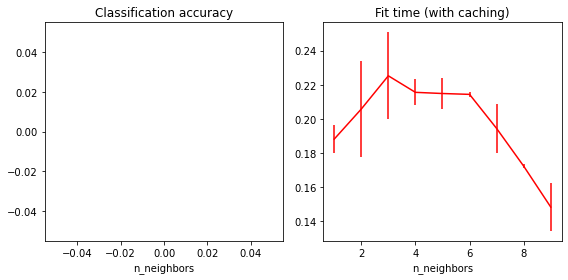

In [22]:
n_neighbors_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# The transformer computes the nearest neighbors graph using the maximum number
# of neighbors necessary in the grid search. The classifier model filters the
# nearest neighbors graph as required by its own n_neighbors parameter.
graph_model = NMSlibTransformer(n_neighbors=max(n_neighbors_list), n_jobs=8, verbose=True)
classifier_model = KNeighborsClassifier(metric='precomputed', n_jobs=-1)

# Note that we give `memory` a directory to cache the graph computation
# that will be used several times when tuning the hyperparameters of the
# classifier.
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    full_model = Pipeline(
        steps=[('graph', graph_model), ('classifier', classifier_model)],
        memory=tmpdir, verbose=True)
    
    param_grid = {'classifier__n_neighbors': n_neighbors_list}
    grid_model = GridSearchCV(full_model, param_grid, n_jobs=-1, cv=2)
    grid_model.fit(X_train, y_train)

# Plot the results of the grid search.
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].errorbar(x=n_neighbors_list,
                 y=grid_model.cv_results_['mean_test_score'],
                 yerr=grid_model.cv_results_['std_test_score'])
axes[0].set(xlabel='n_neighbors', title='Classification accuracy')
axes[1].errorbar(x=n_neighbors_list, y=grid_model.cv_results_['mean_fit_time'],
                 yerr=grid_model.cv_results_['std_fit_time'], color='r')
axes[1].set(xlabel='n_neighbors', title='Fit time (with caching)')
fig.tight_layout()
plt.show()

In [18]:
graph_model = NMSlibTransformer(n_jobs=8, verbose=True)
classifier_model = KNeighborsClassifier(metric='precomputed', n_jobs=-1)
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    full_model = Pipeline(
        steps=[('graph', graph_model), ('classifier', classifier_model)],
        memory=tmpdir, verbose=True)

    benchmark(full_model)

________________________________________________________________________
Training: 
Pipeline(memory='C:\\Users\\K\\AppData\\Local\\Temp\\sklearn_graph_cache_ro7p99ov',
         steps=[('graph', NMSlibTransformer(n_jobs=8, verbose=True)),
                ('classifier',
                 KNeighborsClassifier(metric='precomputed', n_jobs=-1))],
         verbose=True)
Sparse input. Proceding without converting...
Index-time parameters M: 30 n_threads: 8 efConstruction: 100 post:0
Indexing time = 172.706257 (sec)
Query-time parameter efSearch: 100
kNN time total=36.572800 (sec), per query=0.000306 (sec), per query adjusted for thread number=0.002445 (sec)
[Pipeline] ............. (step 1 of 2) Processing graph, total= 3.5min
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
train time: 210.4915s
Query-time parameter efSearch: 100
kNN time total=9.999797 (sec), per query=0.000251 (sec), per query adjusted for thread number=0.002005 (sec)
predict time: 11.9726s
average pre